In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
from sklearn.linear_model import LinearRegression
from pprint import pprint


# Deliverables
1. Research Question
    - Can we predict the S&P price over the next 10 days using financial indicators?
3. Hypothesis
    - Null: There are no correlations
    - Alternative: There are correlations

In [2]:
bond_yield_df = pd.read_csv("Bond yield.csv")
cpi_df = pd.read_csv("Consumer price index.csv")
dj_df = pd.read_csv("Dow Jones.csv")
usd_eur_df = pd.read_csv("USD_EUR.csv")
usd_jpy_df = pd.read_csv("USD_JPY.csv")
gdp_df = pd.read_csv("GDP.csv")
national_hpi_df = pd.read_csv("National home price index.csv")
sp_df = pd.read_csv("S&P Price.csv")

dfs = [bond_yield_df, cpi_df, dj_df, usd_eur_df, usd_jpy_df, gdp_df, national_hpi_df, sp_df]

In [3]:
for i in range(len(dfs)):
    dfs[i].columns.values[0] = 'date'
    dfs[i] = dfs[i].drop_duplicates(subset="date", keep="first") 
    
    dfs[i].set_index('date', inplace=True)
    dfs[i].index = pd.to_datetime(dfs[i].index, errors="coerce").normalize()

    dfs[i] = dfs[i][~dfs[i].index.duplicated(keep="first")]
    


In [4]:
merged_df = pd.concat(dfs, axis=1)

In [5]:
df = merged_df[['Value', 'DJIA', 'GDP', 'DGS10', 'CSUSHPINSA', 'CPIAUCSL', 'EURO', 'JPY']]
df.columns = ['SP_price','dow_jones','gdp','bond_yield','home_price_index','consumer_price_index','eur','jpy']

df.reset_index(inplace=True)
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
df.set_index("date", inplace=True) 
df = df.reindex(full_date_range)
df.index.name = "date"

df= df.ffill()



In [6]:
def insert_mirrored_rows(df, num_rows=30):
    """
    Insert chronologically mirrored data point at head and tail of df
    """
    df = df.copy()
    mirrored_rows_head = df.iloc[:num_rows].copy()
    mirrored_rows_head = mirrored_rows_head.iloc[::-1].reset_index(drop=True)

    mirrored_rows_tail = df.iloc[-num_rows:].copy()
    mirrored_rows_tail = mirrored_rows_tail.iloc[::-1].reset_index(drop=True)

    df_extended = pd.concat([mirrored_rows_head, df, mirrored_rows_tail], ignore_index=True)
    
    return df_extended

In [7]:
df['SP_price_ln'] = np.log(df['SP_price'])
df['dow_jones'] = pd.to_numeric(df['dow_jones'].str.replace(',', '', regex=True))

extended_df = insert_mirrored_rows(df['SP_price'].copy(), 200)
df.dtypes

SP_price                float64
dow_jones               float64
gdp                     float64
bond_yield              float64
home_price_index        float64
consumer_price_index    float64
eur                     float64
jpy                     float64
SP_price_ln             float64
dtype: object

In [8]:
ma30_df = df.rolling(window=30).mean().reset_index().iloc[30:-30].reset_index(drop=True)
ma100_df = df.rolling(window=100).mean().reset_index().iloc[100:-100].reset_index(drop=True)
ma200_df = df.rolling(window=200).mean().reset_index().iloc[200:-200].reset_index(drop=True)
df['SP_MA_30'] = df['SP_price'].rolling(window=30).mean()
df['SP_MA_100'] = df['SP_price'].rolling(window=100).mean()
df['SP_MA_200'] = df['SP_price'].rolling(window=200).mean()


In [9]:

df.reset_index(inplace=True)  # Move the index back to a column
df.head(500)


,date,SP_price,dow_jones,gdp,bond_yield,home_price_index,consumer_price_index,eur,jpy,SP_price_ln,SP_MA_30,SP_MA_100,SP_MA_200
0,1927-12-30,17.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.871302,NaN,NaN,NaN
1,1927-12-31,17.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.871302,NaN,NaN,NaN
2,1928-01-01,17.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.871302,NaN,NaN,NaN
3,1928-01-02,17.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.871302,NaN,NaN,NaN
4,1928-01-03,17.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.876949,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1929-05-08,26.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.264996,25.596000,25.3345,24.39255
496,1929-05-09,26.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.258865,25.642333,25.3411,24.41285
497,1929-05-10,26.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.271089,25.694333,25.3500,24.43550
498,1929-05-11,26.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.271089,25.737000,25.3560,24.45745


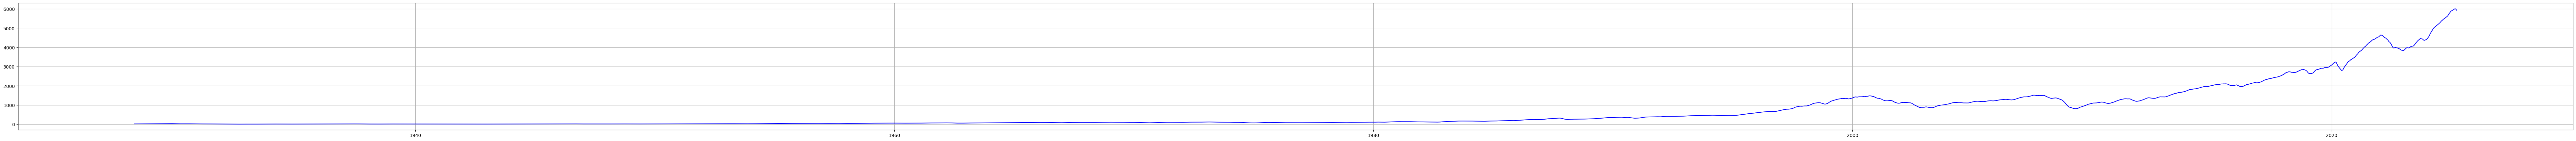

In [10]:
plt.figure(figsize=(100, 5))
plt.plot(df['date'], df['SP_MA_100'], linestyle='-', color='b', markersize=6, label="Data Line")
# Add labels and title

plt.grid(True)

plt.show()

In [11]:
df_first_of_month = df[df['date'].dt.day == 1]

## Add timeseries features
- For each daily feature, get the last 10 days for that feature

In [12]:
df['dow_jones_ln'] = np.log(df['dow_jones'])
df['gdp_ln'] = np.log(df['gdp'])
df['home_price_index_ln'] = np.log(df['home_price_index'])
df['bond_yield_ln'] = np.log(df['bond_yield'])


In [13]:
daily_features = ["SP_price_ln", "dow_jones_ln", "eur", "jpy"]

for f in daily_features:
    df[f + f"+10"] = df[f].shift(-10)
for f in daily_features:
    for i in range(1,11):
        df[f + f"-{i}"] = df[f].shift(i)
df.iloc[35177:35187]

,date,SP_price,dow_jones,gdp,bond_yield,home_price_index,consumer_price_index,eur,jpy,SP_price_ln,...,jpy-1,jpy-2,jpy-3,jpy-4,jpy-5,jpy-6,jpy-7,jpy-8,jpy-9,jpy-10
35177,2024-04-21,4967.23,37986.40,29016.714,4.62,320.918,313.016,0.9384,154.63,8.510618,...,154.63,154.63,154.63,154.38,154.71,154.27,153.28,153.28,153.28,153.27
35178,2024-04-22,5010.60,38239.98,29016.714,4.62,320.918,313.016,0.9384,154.84,8.519311,...,154.63,154.63,154.63,154.63,154.38,154.71,154.27,153.28,153.28,153.28
35179,2024-04-23,5070.55,38503.69,29016.714,4.61,320.918,313.016,0.9343,154.82,8.531205,...,154.84,154.63,154.63,154.63,154.63,154.38,154.71,154.27,153.28,153.28
35180,2024-04-24,5071.63,38460.92,29016.714,4.65,320.918,313.016,0.9345,155.34,8.531418,...,154.82,154.84,154.63,154.63,154.63,154.63,154.38,154.71,154.27,153.28
35181,2024-04-25,5048.42,38085.80,29016.714,4.70,320.918,313.016,0.9320,155.65,8.526831,...,155.34,154.82,154.84,154.63,154.63,154.63,154.63,154.38,154.71,154.27
35182,2024-04-26,5099.96,38239.66,29016.714,4.67,320.918,313.016,0.9349,158.33,8.536988,...,155.65,155.34,154.82,154.84,154.63,154.63,154.63,154.63,154.38,154.71
35183,2024-04-27,5099.96,38239.66,29016.714,4.67,320.918,313.016,0.9349,158.33,8.536988,...,158.33,155.65,155.34,154.82,154.84,154.63,154.63,154.63,154.63,154.38
35184,2024-04-28,5099.96,38239.66,29016.714,4.67,320.918,313.016,0.9349,158.33,8.536988,...,158.33,158.33,155.65,155.34,154.82,154.84,154.63,154.63,154.63,154.63
35185,2024-04-29,5116.17,38386.09,29016.714,4.63,320.918,313.016,0.9326,156.33,8.540161,...,158.33,158.33,158.33,155.65,155.34,154.82,154.84,154.63,154.63,154.63
35186,2024-04-30,5035.69,37815.92,29016.714,4.69,320.918,313.016,0.9374,157.80,8.524306,...,156.33,158.33,158.33,158.33,155.65,155.34,154.82,154.84,154.63,154.63


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35516 entries, 0 to 35515
Data columns (total 61 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  35516 non-null  datetime64[ns]
 1   SP_price              35516 non-null  float64       
 2   dow_jones             16528 non-null  float64       
 3   gdp                   28574 non-null  float64       
 4   bond_yield            23094 non-null  float64       
 5   home_price_index      13964 non-null  float64       
 6   consumer_price_index  28574 non-null  float64       
 7   eur                   16331 non-null  float64       
 8   jpy                   19804 non-null  float64       
 9   SP_price_ln           35516 non-null  float64       
 10  SP_MA_30              35487 non-null  float64       
 11  SP_MA_100             35417 non-null  float64       
 12  SP_MA_200             35317 non-null  float64       
 13  dow_jones_ln    

Intercept: 0.03280920073022475
Coefficients: [ 6.21451669e-01  8.42680510e-02  1.23950685e-01  2.18187368e-02
  1.47341878e-02  7.40786643e-02  1.88632267e-02  7.34765807e-02
  2.57651044e-02 -4.97723470e-02  5.24711214e-01 -2.20717376e-01
 -7.02115069e-02 -1.16619650e-01 -1.05385291e-02 -1.58086786e-02
 -1.52969524e-02 -6.80430598e-02 -5.32952726e-02  3.63687711e-02
 -4.24989773e-02  2.11695203e-02  6.06326941e-02  4.51998784e-02
 -3.32282952e-02 -1.29645795e-02  2.23920182e-02 -1.76366472e-02
  2.45571925e-02 -7.06780164e-02 -3.65302244e-04  1.31961875e-04
 -2.86801121e-04  8.66151880e-05  1.15096644e-04  8.83461206e-05
  1.26862957e-04  1.03060739e-04  1.37539698e-04 -1.54173448e-04]


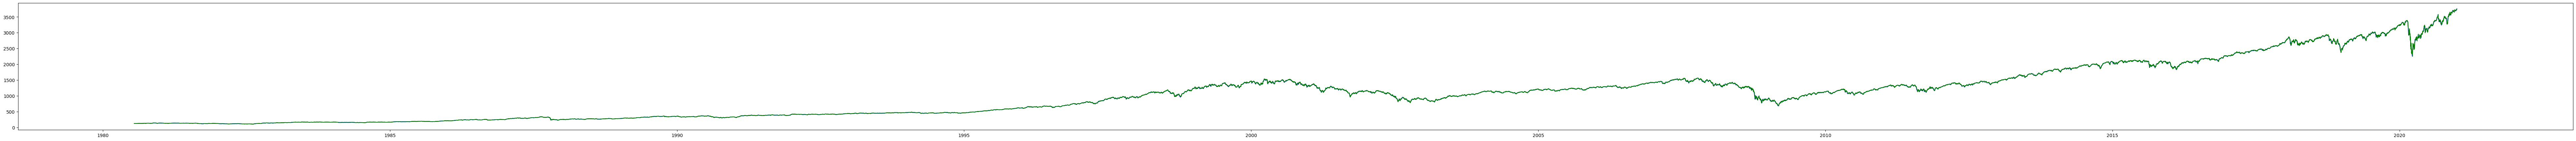

In [15]:
df_filtered = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
col =  df.iloc[:, 21:].columns
df_filtered = df_filtered.dropna(subset=col)

X = df_filtered[col]
y = df_filtered['SP_price_ln+10']

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Predict on new data
predictions = model.predict(X)

plt.figure(figsize=(100, 5))
plt.plot(df_filtered['date'], df_filtered['SP_price'], linestyle='-', color='b', markersize=6, label="data")
plt.plot(df_filtered['date'], math.e**predictions, linestyle='-', color='g', markersize=6, label="data")
plt.show()

In [16]:
X_new = df[df['date'] == '2020-12-31'][col]

# Make the prediction
predicted_ln = model.predict(X_new)

# Convert the log prediction back to the actual price
predicted_price = np.exp(predicted_ln)

# Print the predicted price
print(f"Predicted S&P price for 2021-01-10: {predicted_price[0]:.2f}")

value = df[df['date'] == '2020-12-31']['SP_price'].values[0]
print(f"Actual S&P price for 2021-01-10: {value}")


Predicted S&P price for 2021-01-10: 3745.58
Actual S&P price for 2021-01-10: 3756.07


In [17]:
refined = []
for i in range(len(col)):
    if model.coef_[i] > 0.02:
        refined.append(col[i])

Intercept: 0.023111198938928545
Coefficients: [ 1.02239653 -0.32396707  0.17183555 -0.1017105   0.0810716  -0.05076998
  0.20677261  0.17395452 -0.18010856 -0.03914211  0.03233001  0.03458694
  0.01969292 -0.0520996 ]


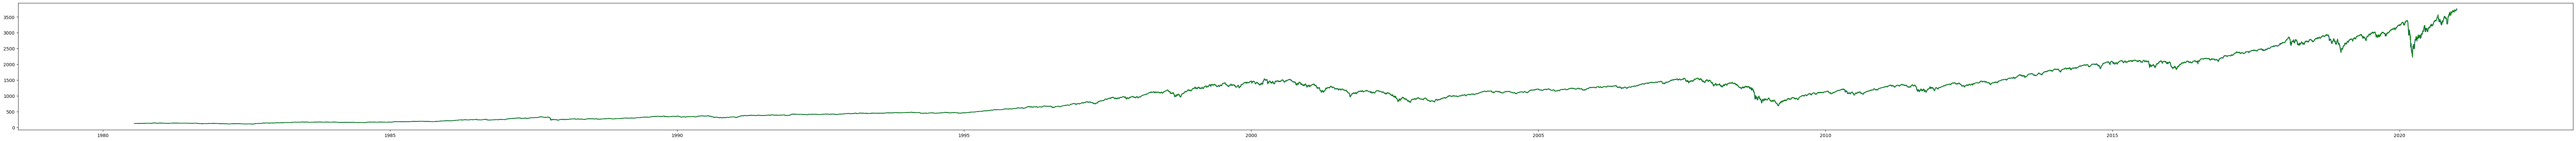

In [18]:
col =  refined
X = df_filtered[col]
y = df_filtered['SP_price_ln+10']

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Predict on new data
predictions2 = model.predict(X)

plt.figure(figsize=(100, 5))
plt.plot(df_filtered['date'], df_filtered['SP_price'], linestyle='-', color='b', markersize=6, label="data")
plt.plot(df_filtered['date'], math.e**predictions2, linestyle='-', color='g', markersize=6, label="data")
plt.show()

In [19]:
X_new = df[df['date'] == '2020-12-31'][col]

# Make the prediction
predicted_ln = model.predict(X_new)

# Convert the log prediction back to the actual price
predicted_price = np.exp(predicted_ln)

# Print the predicted price
print(f"Predicted S&P price for 2021-01-10: {predicted_price[0]:.2f}")

value = df[df['date'] == '2020-12-31']['SP_price'].values[0]
print(f"Actual S&P price for 2021-01-10: {value}")


Predicted S&P price for 2021-01-10: 3739.60
Actual S&P price for 2021-01-10: 3756.07


In [23]:
df_model3 = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
normalized = df_model3.copy()
scaler = StandardScaler()
y_col = "SP_price_ln"
features = normalized.drop(columns=["date",y_col,"SP_price"])
y=df_model3[y_col]
scaled_array = scaler.fit_transform(features)
normalized = pd.DataFrame(scaled_array, index=features.index, columns=features.columns)
normalized[y_col] = y

n = len(normalized)
def adj_r2(R2, p):
    """Adjusted r^2 score from R^2, and number of features"""
    return 1-(1-R2)*(n-1)/(n-p-1)

# Model 3 (using greedy algorithm)
mod_3_scores = []
for c in normalized.columns:
    if c == y_col: continue
    model = LinearRegression(fit_intercept=True)
    
    working_df = normalized.dropna(subset=[y_col,c])
    col = working_df[c].to_numpy().reshape(-1,1)
    model.fit(col,working_df[y_col])
    score = adj_r2(model.score(col,working_df[y_col]),1)
    mod_3_scores.append((c,score))

mod_3_scores = sorted(mod_3_scores, key=lambda x: x[1],reverse=True)
print("Sorted scores for individual linear regressions:")
pprint(mod_3_scores)
print()

mod_3_score = 0
mod_3_cols = []
reg3 = LinearRegression(fit_intercept=True)
for c,_ in mod_3_scores:
    working_df = normalized.dropna(subset=mod_3_cols+[c,y_col])
    X = working_df[mod_3_cols + [c]]
    reg3.fit(X,working_df[y_col])
    score = adj_r2(reg3.score(X,working_df[y_col]),len(mod_3_cols) + 1)
    if score > mod_3_score:
        mod_3_score = score
        mod_3_cols += [c]

final_scaler = StandardScaler()

working_df = df_model3.dropna(subset=mod_3_cols + [y_col])
X3_raw = working_df[mod_3_cols]
X3_scaled = pd.DataFrame(final_scaler.fit_transform(X3_raw), columns=mod_3_cols)

reg3.fit(X3_scaled, working_df[y_col])
trained_features = mod_3_cols.copy()



Sorted scores for individual linear regressions:
[('SP_price_ln-1', 0.9999476422371146),
 ('SP_price_ln-2', 0.9998656674550543),
 ('SP_price_ln-3', 0.999787497787209),
 ('SP_price_ln-4', 0.9997019743210989),
 ('SP_price_ln-5', 0.9996169105362595),
 ('SP_price_ln-6', 0.999534514507075),
 ('SP_price_ln-7', 0.9994541351098337),
 ('SP_price_ln-8', 0.9993754586401518),
 ('SP_price_ln-9', 0.9992995605668263),
 ('SP_price_ln-10', 0.9992251790823573),
 ('SP_price_ln+10', 0.9992246287997728),
 ('dow_jones_ln', 0.9967408215336007),
 ('dow_jones_ln-1', 0.9967250777499203),
 ('dow_jones_ln-2', 0.9966479920185408),
 ('dow_jones_ln-3', 0.9965768582704644),
 ('dow_jones_ln-4', 0.9964921123776093),
 ('dow_jones_ln-5', 0.9964067586742129),
 ('dow_jones_ln-6', 0.9963242728148939),
 ('dow_jones_ln-7', 0.996243848156134),
 ('dow_jones_ln-8', 0.996162047096651),
 ('dow_jones_ln+10', 0.9960909810492908),
 ('dow_jones_ln-9', 0.9960827609293499),
 ('dow_jones_ln-10', 0.9960043704770286),
 ('gdp_ln', 0.9518202

In [24]:
X_filtered = df[df['date'] == '2020-12-31']
X_new_raw = X_filtered[trained_features].copy()

# Fill missing columns if needed
for col in trained_features:
    if col not in X_new_raw.columns:
        X_new_raw[col] = np.nan  # or 0

X_new_scaled = pd.DataFrame(final_scaler.transform(X_new_raw), columns=trained_features)

predicted_ln = reg3.predict(X_new_scaled)
predicted_price = np.exp(predicted_ln)

print(f"Predicted S&P ln price for 2021-01-10: {predicted_ln[0]:.2f}")
print(f"Predicted S&P price for 2021-01-10: {predicted_price[0]:.2f}")

value = df[df['date'] == '2020-12-31']['SP_price'].values[0]
print(f"Actual S&P price for 2021-01-10: {value}")

print("Coefficients:", reg3.coef_)
print("Intercept:", reg3.intercept_)
print("Input features:", X_new)


Predicted S&P ln price for 2021-01-10: 8.23
Predicted S&P price for 2021-01-10: 3751.36
Actual S&P price for 2021-01-10: 3756.07
Coefficients: [ 0.83048932 -0.11946906  0.11838172  0.01098596  0.02049823 -0.03226976
  0.0129025   0.02218369  0.08597145  0.52623695 -0.08688794 -0.26611342
  0.04780842 -0.10655904 -0.01001862  0.0048962   0.00580227 -0.01056856
 -0.08315754 -0.02112577]
Intercept: 6.587587598665803
Input features:        SP_price_ln-1  SP_price_ln-2  SP_price_ln-3  SP_price_ln-4  \
33970        8.22471        8.22337       8.225599       8.216915   

       SP_price_ln-6  SP_price_ln-8  SP_price_ln-9  dow_jones_ln-1  \
33970       8.216915       8.213384       8.212639       10.322512   

       dow_jones_ln-10   eur-2   eur-3   eur-4   eur-7  eur-9  
33970        10.316142  0.8163  0.8184  0.8191  0.8205  0.822  
